# Welcome to the Advanced Data Techniques practical session

This session is led by **Eline Meijer** and **Alejandro Guerrero-López**.

In this notebook, we will work with **MALDI-TOF mass spectrometry data**, specifically the **DRIAMS B database**, which contains routine MALDI-TOF MS data from the Canton Hospital Basel-Land.

Our objectives for this practical session are to:

- Perform **basic preprocessing** of the MALDI-TOF MS data  
- Apply **dimensionality reduction techniques** for visualization, such as t-SNE and UMAP  
- Solve **species classification tasks** using both **MLP (Multilayer Perceptron)** models and interpretable models like **XGBoost, Random Forest, and Logistic Regression**  
- Demonstrate **model explainability** using **SHAP values**  
- Explore **interpretability** of learned representations with **t-SNE** and **UMAP** visualizations

Let's get started!




---

## Setup and Data Download Instructions

Before we start, please download the **DRIAMS B database** from the following link:

[https://datadryad.org/dataset/doi:10.5061/dryad.bzkh1899q#usage](https://datadryad.org/dataset/doi:10.5061/dryad.bzkh1899q#usage)

> **Important:** Only download the **DRIAMS B** dataset, as the other datasets are very large and not needed for this session.

Once downloaded, upload the `driams_b.tar.gz` file to the **same Google Drive folder** where this Colab notebook is saved.

In the next code cell, we will:

- Mount your Google Drive  
- Install necessary Python libraries  
- Unzip and extract the DRIAMS B dataset for use in this notebook  

Make sure the `driams_b.tar.gz` file is correctly placed before running the next cell.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Set-up

In [ ]:
!pip install maldi-nn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3

In [ ]:
#!tar -xzvf "/content/drive/MyDrive/ESCMID-AI-Data-Advances-Techniques/DRIAMS/DRIAMS-B/DRIAMS_B.tar.gz" -C "/content/drive/MyDrive/ESCMID-AI-Data-Advances-Techniques/DRIAMS/DRIAMS-B"

In [ ]:
import maldi_nn.utils.data
import pandas as pd
import os
import numpy as np
from importlib.resources import files
import maldi_nn.spectrum  as maldi_spectrum

## Set your path
Open the folder icon on your left


<----------------------------

And navigate until you find the folder called DRIAMS-B. Do "right-click" on it and select "Copy path". Then, paste your path below substituing Eline's or Alex' path.

In [ ]:
DRIAMS_B_ROOT = '/content/drive/MyDrive/ESCMID-AI-Data-Advances-Techniques/DRIAMS/DRIAMS-B/'
#DRIAMS_B_ROOT = '/content/drive/MyDrive/DocenciaUC3M/ESCMID-AI-Data-Advances-Techniques/DRIAMS/DRIAMS-B'



---



## Loading MALDI-TOF Spectra

For this session, we will use a well-established **maldi-nn** GitHub repository, which is widely used in MALDI-TOF data analysis.

If you are not a data scientist, don’t worry about the implementation details — the important part is to understand that this code **reads and processes MALDI-TOF spectra** from the DRIAMS B dataset in a format that we can use for machine learning.

We will focus on using the processed data for downstream analysis, so you can safely treat this step as a “black box” that prepares the data for us.


In [ ]:
# @title
import os
import pandas as pd
import numpy as np
from maldi_nn.spectrum import SpectrumObject

def load_spectra_with_species(DRIAMS_ROOT, spectra_type="raw"):
    """
    Loads all spectrum .txt files and pairs them with species info,
    filtering to only include specific microorganisms (genus + species).

    Args:
        DRIAMS_ROOT (str): Path to the root directory of the DRIAMS dataset.

    Returns:
        - spectra_list: list of SpectrumObject (with .species and .code attributes)
        - df: DataFrame with columns ['species', 'code']
    """

    # List of allowed species (genus + species), exact match required
    allowed_species = {
        "Escherichia coli",
        "Staphylococcus aureus",
        "Staphylococcus epidermidis",
        "Enterococcus faecalis",
        "Pseudomonas aeruginosa",
        "Klebsiella pneumoniae",
        "Streptococcus agalactiae",
        "Candida albicans",
        "Candida glabrata",
        "Staphylococcus haemolyticus",
        "Staphylococcus hominis",
        "Streptococcus pyogenes",
        "Citrobacter koseri",
        "Staphylococcus lugdunensis",
        "Streptococcus anginosus",
        "Enterobacter cloacae"
    }

    print("Step 1: Collecting all .txt spectrum file paths...")
    spectrum_paths = []

    # Walk through all directories under the root to find spectrum .txt files
    for root, dirs, files in os.walk(DRIAMS_ROOT):
        if spectra_type in root:
            for f in files:
                if f.endswith(".txt"):
                    full_path = os.path.join(root, f)
                    rel_path = "/".join(full_path.split("/")[-4:])
                    spectrum_paths.append((rel_path, full_path))

    print("Step 2: Parsing species data from _clean.csv files...")
    species_lookup = {}

    for root, dirs, files in os.walk(DRIAMS_ROOT):
        if "id" in root:
            for f in files:
                if f.endswith("_clean.csv"):
                    path = os.path.join(root, f)
                    try:
                        df = pd.read_csv(path)
                        dataset = root.split("/")[-3]
                        year = root.split("/")[-1]
                        df["code"] = f"{dataset}/{spectra_type}/{year}/" + df["code"] + ".txt"
                        for _, row in df.iterrows():
                            code = row["code"]
                            species = row["species"]
                            species_lookup[code] = species
                    except Exception as e:
                        print(f"Error reading {path}: {e}")

    print("Step 3: Loading spectra and attaching metadata with filtering...")
    spectra_list = []
    records = []

    for rel_path, full_path in spectrum_paths:
        try:
            species = species_lookup.get(rel_path, None)
            # Filter: skip if species not in allowed_species or None
            if species is None or species not in allowed_species:
                continue

            spec_obj = SpectrumObject.from_tsv(full_path)
            spec_obj.intensity = np.array(spec_obj.intensity[1:], dtype=float)
            spec_obj.mz = np.array(spec_obj.mz[1:], dtype=float)

            code = os.path.splitext(os.path.basename(rel_path))[0]

            spectra_list.append(spec_obj)
            records.append({
                "species": species,
                "code": code
            })
        except Exception as e:
            print(f"Error loading spectrum {rel_path}: {e}")

    df = pd.DataFrame(records)

    print(f"Loaded {len(spectra_list)} spectra filtered by selected species.")
    return spectra_list, df


In [ ]:
spectra, metadata = load_spectra_with_species(DRIAMS_B_ROOT)

Step 1: Collecting all .txt spectrum file paths...
Step 2: Parsing species data from _clean.csv files...
Step 3: Loading spectra and attaching metadata...
Loaded 1259 spectra.


# Pre-processing

🧠 **Question**: Why are these pre-processing steps important?

## Preprocessing Steps Explained

Before we can train any machine learning model on MALDI-TOF spectra, it is essential to preprocess the raw data to reduce noise, correct artifacts, and standardize the measurements. The preprocessing steps we use are **well-established in the MALDI-TOF literature** and help improve model performance and reliability.

Here are the steps we apply sequentially using the `maldi_spectrum.SequentialPreprocessor`:

1. **Variance Stabilization (`VarStabilizer` with method="sqrt")**  
   - Applies a square root transformation to stabilize the variance across intensity values, reducing heteroscedasticity common in spectral data.

2. **Smoothing (`Smoother` with halfwindow=10)**  
   - Applies a smoothing filter to reduce random noise while preserving peak shapes, improving signal clarity.

3. **Baseline Correction (`BaselineCorrecter` with method="SNIP", iterations=20)**  
   - Removes the slowly varying background signal (baseline) from spectra, which can obscure true peaks.

4. **Normalization (`Normalizer` with sum=1)**  
   - Scales the spectra so that the total intensity sums to one, making spectra comparable across samples.

5. **Binning (`Binner` with step=3)**  
   - Aggregates adjacent m/z values into bins, reducing dimensionality and compensating for small shifts in peak positions.

Together, these steps produce clean, comparable spectral data ready for downstream machine learning analysis.


In [ ]:
# Define preprocessor and its steps
preprocessor = maldi_spectrum.SequentialPreprocessor(
    maldi_spectrum.VarStabilizer(method="sqrt"),
    maldi_spectrum.Smoother(halfwindow=10),
    maldi_spectrum.BaselineCorrecter(method="SNIP", snip_n_iter=20),
    maldi_spectrum.Normalizer(sum=1),
    maldi_spectrum.Binner(step=3)
)

#Apply preprocessing steps
spectra_preprocessed = [preprocessor(spectrum) for spectrum in spectra]

NameError: name 'maldi_spectrum' is not defined

In [ ]:
species_counts = metadata['species']
print(species_counts)
print(len(spectra_preprocessed))

In [ ]:
print(spectra_preprocessed[1])
print(metadata.loc[1])

# What is a MALDI-TOF MS spectra?

**1. What does this spectrum show?**

The MALDI-TOF spectrum is essentially a molecular fingerprint. It displays ionized molecules from a sample—commonly proteins or peptides—detected by their mass-to-charge ratio (m/z). Each peak in the spectrum corresponds to a different ionized molecule. So, when you see a sharp rise on the graph, you're actually seeing the presence of a specific molecule, like a small protein or peptide.

**2. Why is this useful for identifying microorganisms?**

Every microorganism—bacteria, fungi, and others—has a unique set of proteins. These proteins generate patterns in the MALDI-TOF spectrum, much like a biological barcode. By comparing these patterns to a other spectra or a spectral reference database, microbiologists can quickly and accurately identify the microorganism.

**3. What does the x-axis represent?**

The horizontal axis in a MALDI-TOF spectrum is the mass-to-charge ratio (m/z). This ratio reflects how heavy a molecule is, relative to its charge. In the MALDI process, most ions are singly charged (charge = +1), so the m/z usually just reflects the actual mass of the molecule. Lighter ions—or those with higher charges—reach the detector faster and appear earlier (lower m/z).

**4. What does the y-axis show?**

The vertical axis represents intensity, or more specifically, the number of ions detected at each m/z value. A higher peak means more ions of that specific mass were detected. While it doesn’t give an exact concentration, it gives a rough sense of how abundant each molecule is in the sample.

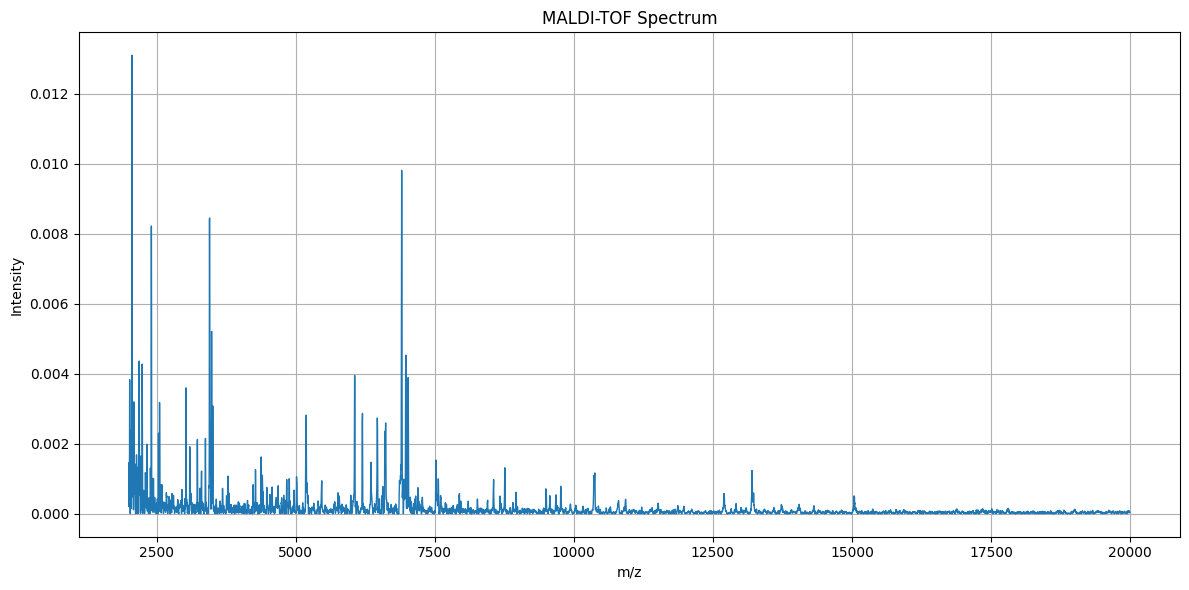

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Select one spectrum index to visualize
idx = 1

# Preprocessed spectrum
mz_pre = spectra_preprocessed[idx].mz
intensity_pre = spectra_preprocessed[idx].intensity

# Raw (unprocessed) spectrum
mz_raw = spectra[idx].mz
intensity_raw = spectra[idx].intensity

# Create subplot figure with 2 side-by-side plots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Preprocessed Spectrum", "Raw Spectrum"))

# Add preprocessed spectrum trace
fig.add_trace(
    go.Scatter(x=mz_pre, y=intensity_pre, mode='lines', name='Preprocessed'),
    row=1, col=1
)

# Add raw spectrum trace
fig.add_trace(
    go.Scatter(x=mz_raw, y=intensity_raw, mode='lines', name='Raw', line=dict(color='orange')),
    row=1, col=2
)

# Update layout
fig.update_layout(
    height=400, width=1000,
    title_text="Comparison of Preprocessed vs Raw MALDI-TOF Spectra",
    xaxis_title="m/z",
    yaxis_title="Intensity",
    xaxis2_title="m/z",
    yaxis2_title="Intensity"
)

fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

fig.show()


# Harmonizing Effect of Preprocessing

Raw MALDI-TOF spectra often contain noise, baseline drifts, and intensity variations that make it difficult to identify meaningful patterns or clusters directly from the data. When visualized with dimensionality reduction techniques like t-SNE, the raw spectra tend to appear scattered and mixed, showing poor separation between different sample groups or species.

By applying our carefully chosen preprocessing steps—variance stabilization, smoothing, baseline correction, normalization, and binning—we effectively **harmonize the spectral data**. This process reduces technical variability and emphasizes biologically relevant signals.

As a result, when we apply t-SNE to the preprocessed spectra, we observe **clearer clustering and better separation** of sample groups. This improved cluster structure reflects that preprocessing helps highlight the underlying biological differences and makes downstream machine learning tasks, such as classification, more accurate and reliable.

In summary, preprocessing acts as a crucial harmonizing step, transforming noisy raw data into a structured format that reveals meaningful patterns.


### Bin the maldi spectra
Tip: Use the maldi_spectrum.SequentialPreprocessor() function as before.


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, to_hex

# Define preprocessor and its steps
preprocessor = maldi_spectrum.SequentialPreprocessor(
    maldi_spectrum.Binner(step=3)
)

# To do a t-SNE we must ensure that, at least, all of them are same shape, so we msut do binning at least.
raw_spec = [preprocessor(spectrum) for spectrum in spectra]


# Convert both things into a numpy arrays to work with tSNE
raw_spec = np.vstack([spectrum.intensity for spectrum in raw_spec])
preprocessed_spec = np.vstack([spectrum.intensity for spectrum in spectra_preprocessed])



### Create a TSNE plot of before and after preprocessing steps

# Split stratified dataset into training/validation/test set

🧠 **Question**: Why is stratified splitting important in this dataset?

In [ ]:
min_species_count = 5

# Step 1: Remove species with only one sample
species_counts = metadata['species'].value_counts()
species_to_keep = species_counts[species_counts > min_species_count].index
metadata_filtered = metadata[metadata['species'].isin(species_to_keep)].copy()

# Get the indices of the spectra to keep
indices_to_keep = metadata_filtered.index.tolist()

# Filter the preprocessed spectra based on the filtered metadata
spectra_preprocessed_filtered = [spectra_preprocessed[i] for i in indices_to_keep]

# Step 2: Remove spectra with species containing '!MIX'
metadata_filtered = metadata_filtered[~metadata_filtered['species'].str.contains('MIX!')].copy()

# Update the indices to keep based on the newly filtered metadata
indices_to_keep_no_mix = metadata_filtered.index.tolist()

# Filter the preprocessed spectra again based on the 'no !MIX' criteria
spectra_preprocessed_final = [spectra_preprocessed_filtered[i] for i in range(len(spectra_preprocessed_filtered)) if indices_to_keep[i] in indices_to_keep_no_mix]


print(f"Number of spectra after removing single-sample species and MIX!: {len(spectra_preprocessed_final)}")
print(f"Number of entries in metadata after filtering: {len(metadata_filtered)}")


# Step 3: Create training, validation, and test sets
from sklearn.model_selection import train_test_split

# Ensure the filtered metadata and spectra are aligned
assert len(metadata_filtered) == len(spectra_preprocessed_final)

# Reset index of filtered metadata to align with filtered spectra list
metadata_filtered = metadata_filtered.reset_index(drop=True)

# Split the indices for consistent splitting of metadata and spectra
indices = np.arange(len(metadata_filtered))

# First split: 80% training + validation, 20% test
train_val_indices, test_indices = train_test_split(
    indices,
    test_size=0.2,
    stratify=metadata_filtered['species'],
    random_state=42
)

# Second split: Split the 80% into 60% training and 20% validation
# Calculate the proportion of the original dataset that is validation
# Validation size relative to the combined train+val set: 20% / 80% = 0.25
train_indices, val_indices = train_test_split(
    train_val_indices,
    test_size=0.25, # 0.25 of the 80% is 20% of the total
    stratify=metadata_filtered.loc[train_val_indices, 'species'],
    random_state=42
)

# Get the corresponding metadata and spectra subsets
metadata_train = metadata_filtered.loc[train_indices].reset_index(drop=True)
spectra_train = [spectra_preprocessed_final[i] for i in train_indices]

metadata_val = metadata_filtered.loc[val_indices].reset_index(drop=True)
spectra_val = [spectra_preprocessed_final[i] for i in val_indices]

metadata_test = metadata_filtered.loc[test_indices].reset_index(drop=True)
spectra_test = [spectra_preprocessed_final[i] for i in test_indices]

print(f"\nTraining set size: {len(spectra_train)}")
print(f"Validation set size: {len(spectra_val)}")
print(f"Test set size: {len(spectra_test)}")

print("\nTraining set species distribution:")
print(metadata_train['species'].value_counts())

print("\nValidation set species distribution:")
print(metadata_val['species'].value_counts())

print("\nTest set species distribution:")
print(metadata_test['species'].value_counts())


Number of spectra after removing single-sample species and MIX!: 873
Number of entries in metadata after filtering: 873

Training set size: 523
Validation set size: 175
Test set size: 175

Training set species distribution:
species
Escherichia coli               101
Staphylococcus aureus           58
Staphylococcus epidermidis      57
Enterococcus faecalis           36
Pseudomonas aeruginosa          24
Klebsiella pneumoniae           23
Streptococcus agalactiae        17
Candida albicans                14
Candida glabrata                13
Staphylococcus haemolyticus     13
Staphylococcus hominis          10
Streptococcus pyogenes          10
Citrobacter koseri              10
Staphylococcus lugdunensis      10
Streptococcus anginosus         10
Enterobacter cloacae            10
Proteus mirabilis                9
Streptococcus dysgalactiae       8
Morganella morganii              7
Klebsiella oxytoca               7
Propionibacterium acnes          7
Enterococcus faecium             

## Dimensionality Reduction: PCA

When working with high-dimensional MALDI-TOF spectra, reducing dimensionality is crucial to simplify the data, improve visualization, and sometimes enhance machine learning performance. Here, we introduce two common techniques: **Principal Component Analysis (PCA)**.

These techniques are commonly used to understand, quick and simply, how is the latent distribution of my data:

<img align="center" src="http://www.tsc.uc3m.es/~emipar/NOTEBOOKS/PCA_ML_health/pca1.png" width="70%" >

In this sense, **feature extraction** methods exploit the data structure to reduce the dimensionality of the input space


  <img align="center" src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/PCA/FE_intro.jpg" width="40%" >

---

# Principal Component Analysis (PCA)

**Intuition:**  
PCA finds new orthogonal axes (principal components) in the feature space that capture the maximum variance in the data. The first principal component explains the largest possible variance, the second the next largest (uncorrelated to the first), and so on.

- **Mathematically:** PCA performs an eigen-decomposition of the covariance matrix of the data.  
- The eigenvectors correspond to principal components, and eigenvalues indicate the variance explained by each component.  
- By selecting the top **k** components that explain a desired percentage (e.g., 95%) of variance, we reduce dimensionality while retaining most information.  

You can skip the math if you want, but understanding that PCA compresses your data by capturing the main patterns is key.

Here it comes the maths that you can completely skip:



<details>
<summary><b>Mathematical formulation (click to if you are interested in the math behind!)</b></summary>


PCA goal is to obtain a new, reduced  set of $K<D$ orthogonal variables, the so-called principal components. The principal components are linear combinations of the input variables, but sorted in decreasing order of variance.

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/PCA/PCA_1.png" width="40%" >

In matrix notation, the purpose of PCA can be written as finding a projection matrix ${\bf U}$ and transform the $D\times N$ data matrix ${\bf X}$ into the $K \times N$ matrix ${\bf X'}$:

$$ {\bf X'} = {\bf U}^\top {\bf X}^\top$$

Each column of the matrix ${\bf U}$ is a **principal component**, and it will provide a new dimension of the data in the projected space: the principal components act as a vector basis in the projected space.

PCA is **unsupervised**, one does not need targets to compute PCA!!


The PCA algorithm finds the components that maximize the variance contained in the data in a **recursive** way:
* Find the first principal component, ${\bf u}_1$, that maximizes the variance of the mapped data:  ${\bf u}_1^\top {\bf x} $ is of maximum variance.

* Deflate the first principal component from the data ${\bf x^1} = {\bf x} - {\bf u}_1^\top {\bf x} {\bf u}_1$.

* Next, find ${\bf u}_2$ so that ${\bf u}_2^\top {\bf x^1} $ is of maximum variance

* Repeat the deflation of the new principal component from the data and the determination of the projection $\bf u_j$that maximizes the variance of the residual $\bf x^{j-1}$ until obtaining the desired $K < D$ principal components.

$$ {\bf U} = \underset{\bf U} {\mathrm{argmax}} ~{\rm Tr} \left\lbrace {\bf U}^T {\bf X}^T {\bf X} {\bf U}\right\rbrace  = \underset{\bf U} {\mathrm{argmax}} ~{\rm Tr}\left\lbrace {\bf U}^T {\bf C_{XX}} {\bf U}\right\rbrace $$
$$ {\rm s.t.} ~~{\bf U}^T {\bf U}={\bf I}$$



### Partial Least Squares Discriminant Analysis (PLS-DA)

**Intuition:**  
PLS-DA is a supervised dimensionality reduction technique. Unlike PCA, which looks only at the data features, PLS-DA also considers the outcome labels (e.g., species class) while projecting data onto latent components.

- It finds components that maximize covariance between predictors (spectra) and response variables (class labels).  
- This makes PLS-DA particularly useful for classification tasks, as it seeks directions that best separate classes.  

<img align="right" src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/PCA/PLS.png" width="30%" >


**Goal**: Find the projections of the input and output data with maximum covariance:

$$ \begin{array}{rl}{\bf U, V} = &  \underset{\bf U, V} {\mathrm{argmax}} ~{\rm Tr} \left\lbrace{\bf U}^T {\bf X}^T {\bf Y} {\bf V} \right\rbrace \\
= & \underset{\bf U, V} {\mathrm{argmax}} ~{\rm Tr} \left\lbrace {\bf U}^T{\bf C_{XY}} {\bf V} \right\rbrace\\
& {\rm s.t.} ~~{\bf U}^T{\bf U}= {\bf V}^T{\bf V}={\bf I}
\end{array}$$
Which leads to
$$ {\bf U},{\bf V} = {\rm svd}({\bf C_{XY}}) $$

The maximum number of projections is limited by the number of output classes minus one.


---


PCA and PLS-DA are **both dimensionality reduction methods**, but they have different goals and ways of working:

- PCA looks only at the input data (e.g., **MALDI-TOF spectra**) and finds new axes (principal components) that capture the **most variation in the data without considering any extra information** about the bacterial species or sample labels. **It’s an unsupervised method**. This helps visualize overall patterns and variance but may not separate bacterial groups clearly if those groups don’t correspond exactly to the biggest sources of variation.

- PLS-DA, on the other hand, **is a supervised method.** It uses the species labels during the dimensionality reduction to find **components that maximize the separation between bacterial groups**. Instead of just capturing variance, PLS-DA finds directions in the data that are most relevant to distinguishing species.

In simple terms:

* PCA shows you how your samples vary overall, good for exploring the data structure without any prior knowledge.

* PLS-DA shows you how your samples differ based on known groups (species), making it more powerful for classification and biomarker discovery.

So, if your goal is to visualize or discover overall patterns, PCA is great. But if you want to focus on differences that matter biologically — like identifying species-specific signals — PLS-DA often gives clearer, more interpretable results.


# Practical Implementation

We will:

1. Apply PCA to reduce the dimensionality of MALDI-TOF spectra to:  
   - The number of components explaining **95% of the variance**  
   - A fixed **3 components** for easy 3D visualization  

2. Visualize the data in 3D PCA space with species colored  

3. Train and compare a **Random Forest classifier** on:  
   - Raw preprocessed spectra  
   - PCA-reduced spectra (95% variance)  
   - PCA with 3 components  
   - PLS-DA transformed data  

This will show the trade-offs between dimensionality reduction and classification performance.

---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_decomposition import PLSRegression
import plotly.express as px
import pandas as pd

# Prepare numpy arrays from spectra list of SpectrumObjects (assuming .intensity attribute)
X_train = np.vstack([s.intensity for s in spectra_train])
X_val = np.vstack([s.intensity for s in spectra_val])
X_test = np.vstack([s.intensity for s in spectra_test])

# Encode species labels to integers
le = LabelEncoder()
y_train = le.fit_transform(metadata_train['species'])
y_val = le.transform(metadata_val['species'])
y_test = le.transform(metadata_test['species'])

# 1. PCA dimensionality reduction
# TODO ======================= REmove these lines for the student version:
# a) PCA explaining 95% variance
pca_95 = PCA(n_components=0.95, svd_solver='full', random_state=42)
X_train_pca95 = pca_95.fit_transform(X_train)
X_val_pca95 = pca_95.transform(X_val)
X_test_pca95 = pca_95.transform(X_test)
print(f"PCA 95% variance number of components: {pca_95.n_components_}")

# b) PCA fixed to 3 components for visualization
pca_3 = PCA(n_components=3, random_state=42)
X_train_pca3 = pca_3.fit_transform(X_train)
X_val_pca3 = pca_3.transform(X_val)
X_test_pca3 = pca_3.transform(X_test)




PCA 95% variance number of components: 163


In [ ]:
# 2. 3D Visualization of PCA with 3 components


# Prepare a DataFrame for Plotly
df_pca3 = pd.DataFrame({
    'PC1': X_train_pca3[:, 0],
    'PC2': X_train_pca3[:, 1],
    'PC3': X_train_pca3[:, 2],
    'species': metadata_train['species']
})

# Create 3D scatter plot with Plotly Express
fig = px.scatter_3d(
    df_pca3,
    x='PC1', y='PC2', z='PC3',
    color='species',
    title='3D PCA of Training Spectra',
    opacity=0.7,
    width=800,
    height=600,
    labels={'PC1': 'PC1', 'PC2': 'PC2', 'PC3': 'PC3'}
)

# Customize layout for better interactivity
fig.update_traces(marker=dict(size=5))
fig.update_layout(
    legend_title_text='Species',
    legend=dict(itemsizing='constant')
)

fig.show()

In [ ]:
# 3. PLS-DA dimensionality reduction
# We use PLSRegression with number of components = 3
pls = PLSRegression(n_components=3)

pls.fit(X_train, y_train)
X_train_pls = pls.transform(X_train)
X_val_pls = pls.transform(X_val)
X_test_pls = pls.transform(X_test)


# YOUR CODE HERE: NOW, DO YOURSELVES A 3D PLOT OF THE PLS DA LATENT SPACE!




Training Random Forest classifiers on different data representations:

Random Forest ROC-AUC on validation set (Raw preprocessed spectra): 0.9996


<ipython-input-19-354daa0e4848>:23: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



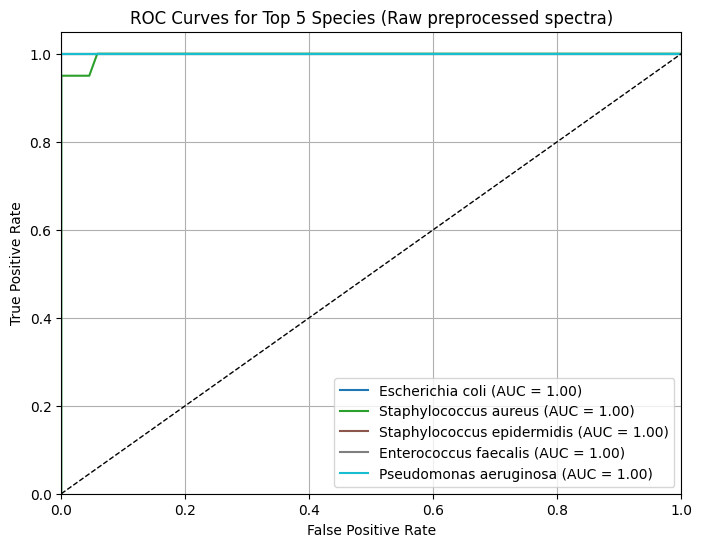

Random Forest ROC-AUC on validation set (PCA (95% variance)): 0.9990


<ipython-input-19-354daa0e4848>:23: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



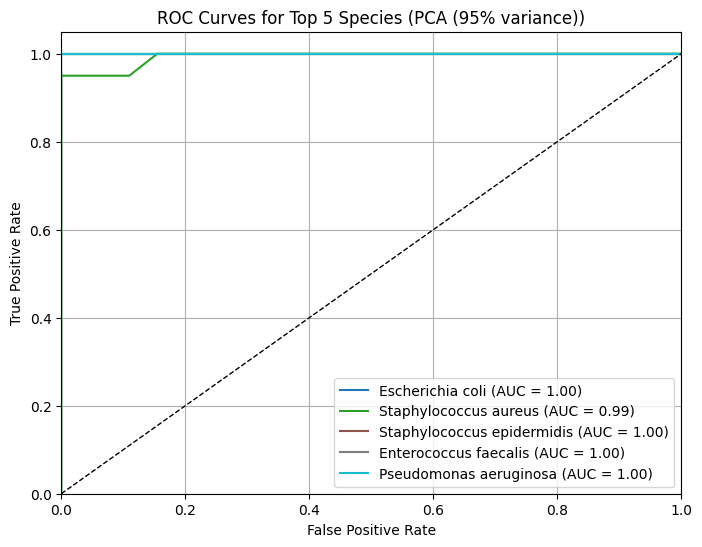

Random Forest ROC-AUC on validation set (PCA (3 components)): 0.9841


<ipython-input-19-354daa0e4848>:23: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



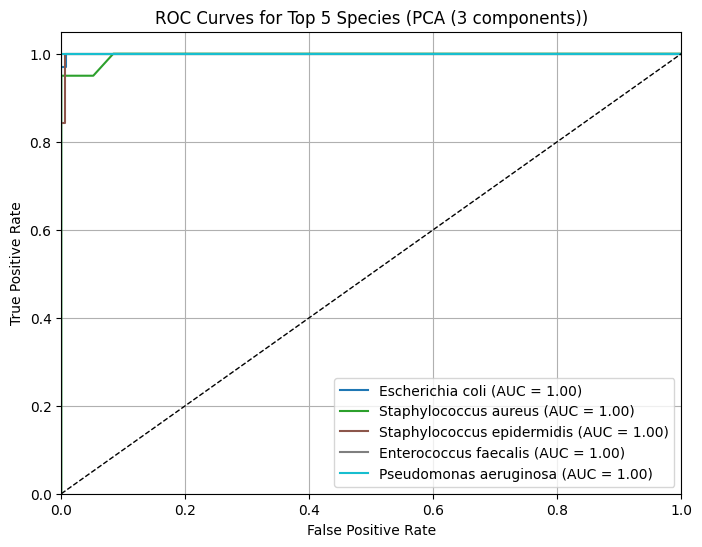

Random Forest ROC-AUC on validation set (PLS-DA (3 components)): 0.9688


<ipython-input-19-354daa0e4848>:23: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



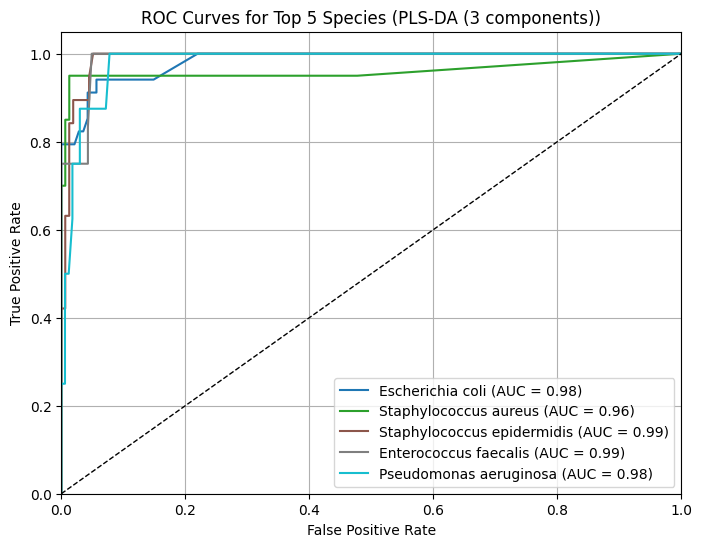

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def train_evaluate_rf_roc(X_train, y_train, X_val, y_val, description="", top_n=5):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Predict probabilities for ROC
    y_proba = clf.predict_proba(X_val)

    # Compute ROC-AUC with 'ovr' average (one-vs-rest) for multiclass
    roc_auc = roc_auc_score(y_val, y_proba, multi_class='ovr', average='weighted')
    print(f"Random Forest ROC-AUC on validation set ({description}): {roc_auc:.4f}")

    # Identify top_n most common classes in y_val for plotting
    unique, counts = np.unique(y_val, return_counts=True)
    top_classes_idx = unique[np.argsort(counts)[-top_n:]][::-1]  # top N by frequency descending
    top_classes_names = [le.classes_[i] for i in top_classes_idx]

    # Plot ROC curves for top_n classes
    plt.figure(figsize=(8, 6))
    colors = plt.cm.get_cmap('tab10', top_n)

    for i, class_idx in enumerate(top_classes_idx):
        # Binarize y_val for current class
        y_val_bin = (y_val == class_idx).astype(int)
        y_score = y_proba[:, class_idx]

        fpr, tpr, _ = roc_curve(y_val_bin, y_score)
        roc_auc_class = auc(fpr, tpr)

        plt.plot(fpr, tpr, color=colors(i),
                 label=f"{top_classes_names[i]} (AUC = {roc_auc_class:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for Top {top_n} Species ({description})')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return roc_auc

print("\nTraining Random Forest classifiers on different data representations:\n")

acc_raw = train_evaluate_rf_roc(X_train, y_train, X_val, y_val, "Raw preprocessed spectra")
acc_pca95 = train_evaluate_rf_roc(X_train_pca95, y_train, X_val_pca95, y_val, "PCA (95% variance)")
acc_pca3 = train_evaluate_rf_roc(X_train_pca3, y_train, X_val_pca3, y_val, "PCA (3 components)")
acc_pls = train_evaluate_rf_roc(X_train_pls, y_train, X_val_pls, y_val, "PLS-DA (3 components)")


# Comparing 3D Visualizations: PCA vs t-SNE vs UMAP vs PLS-DA

Before applying dimensionality reduction for classification, it is helpful to explore how different techniques represent the data in 3D space. Visualization allows us to intuitively assess how well the data separates by species and reveals underlying structure.

In this section, we will apply four common dimensionality reduction methods to the **training set** spectra:

- **PCA (3 components)** — a linear method preserving maximum variance  
- **t-SNE (3 components)** — a nonlinear method optimized for local neighborhood preservation  
- **UMAP (3 components)** — a nonlinear method balancing local and global structure preservation  
- **PLS-DA (3 components)** — a supervised linear method maximizing covariance with species labels  

For each method, we will create an **interactive 3D scatter plot using Plotly**, coloring points by bacterial species. This interactive visualization enables zooming, rotating, and toggling species visibility to better understand clustering patterns.


In [ ]:
import plotly.express as px
import pandas as pd

# Helper function to create plotly 3D scatter plot
def plot_3d_interactive(X, species_labels, title):
    df = pd.DataFrame({
        'Dim1': X[:, 0],
        'Dim2': X[:, 1],
        'Dim3': X[:, 2],
        'Species': species_labels
    })
    fig = px.scatter_3d(
        df,
        x='Dim1', y='Dim2', z='Dim3',
        color='Species',
        title=title,
        opacity=0.7,
        width=800,
        height=600,
        labels={'Dim1': 'Component 1', 'Dim2': 'Component 2', 'Dim3': 'Component 3'}
    )
    fig.update_traces(marker=dict(size=5))
    fig.update_layout(legend_title_text='Species')
    fig.show()

# PCA 3 components (already computed as X_train_pca3)
plot_3d_interactive(X_train_pca3, metadata_train['species'], '3D PCA of Training Spectra')

# t-SNE 3 components (compute now)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, random_state=42, perplexity=30, max_iter=1000)
X_train_tsne3 = tsne.fit_transform(X_train)
plot_3d_interactive(X_train_tsne3, metadata_train['species'], '3D t-SNE of Training Spectra')

# UMAP 3 components (compute now)
import umap
umap_model = umap.UMAP(n_components=3, random_state=42)
X_train_umap3 = umap_model.fit_transform(X_train)
plot_3d_interactive(X_train_umap3, metadata_train['species'], '3D UMAP of Training Spectra')

# PLS-DA 3 components (already computed as X_train_pls)
plot_3d_interactive(X_train_pls, metadata_train['species'], '3D PLS-DA of Training Spectra')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## Why t-SNE and UMAP are not suitable for Dimensionality Reduction in Supervised Tasks

When performing supervised machine learning tasks—such as classifying bacterial species from MALDI-TOF spectra—it is crucial that the dimensionality reduction technique used **learns a fixed transformation** during training. This allows any **new, unseen test samples** to be projected into the **same low-dimensional space** as the training data, enabling consistent and reliable predictions.

### Limitations of t-SNE

**t-Distributed Stochastic Neighbor Embedding (t-SNE)** is a popular nonlinear dimensionality reduction method primarily designed for **visualization**. It works by modeling the pairwise similarities between all samples in the high-dimensional space and tries to preserve those relationships in a low-dimensional embedding.

- **Key issue:** t-SNE requires access to **all data points simultaneously** to compute this embedding.  
- This means that if you get new test samples, you must **recompute the entire t-SNE embedding with both training and new test data combined**.  
- Since t-SNE optimizes the embedding globally, the new low-dimensional coordinates will **change** whenever new samples are added.  
- Consequently, a classifier trained on t-SNE coordinates from the training data **cannot reliably predict** new samples projected with a different embedding.  

Thus, t-SNE **cannot be used as a dimensionality reduction step for supervised learning** in the conventional sense. It is instead an excellent tool for:

- Visualizing complex data structures  
- Interpreting model behavior by projecting learned latent spaces  
- Understanding clusters and relationships in the data  

---
### Limitations of UMAP

**Uniform Manifold Approximation and Projection (UMAP)** shares conceptual similarities with t-SNE, aiming to preserve the topological structure of data in lower dimensions.

- Like t-SNE, UMAP traditionally computes embeddings using **all samples together**, so new samples require **recomputing or approximating the embedding**.  
- While UMAP developers and the community are actively working on methods to **transform new data points into an existing embedding space** (sometimes called “transform” or “embedding projection”), this feature is still **experimental and under development**.  
- For more details and ongoing discussions, see [UMAP GitHub issue #40](https://github.com/lmcinnes/umap/issues/40#issuecomment-362306762).  

Until these capabilities mature, UMAP faces similar practical challenges as t-SNE when used for supervised prediction tasks.

---
### How PCA and PLS-DA Differ

Both **Principal Component Analysis (PCA)** and **Partial Least Squares Discriminant Analysis (PLS-DA)** learn a **fixed linear transformation matrix** (commonly denoted as **W**) from the training data.  

- This matrix **projects any new sample**—including test samples—into the **same low-dimensional space** used for training.  
- This property makes PCA and PLS-DA suitable for supervised tasks where consistent feature extraction is essential.  
- Models trained on these projections can thus be confidently applied to new, unseen samples without retraining the dimensionality reduction step.

---



### Summary

- **t-SNE and UMAP** are **best used as visualization tools** to explore and interpret data or model latent spaces, not as fixed feature extractors for prediction.  
- **PCA and PLS-DA** provide **fixed, learnable transformations** that allow consistent projection of new samples, making them appropriate for supervised learning pipelines.  
- Understanding these differences is essential for designing robust ML workflows in microbiology and biomedical applications.


# Implementing Classical Machine Learning models and biomarker discovery

Now that we have explored dimensionality reduction and visualized our MALDI-TOF data, we will implement classical machine learning (ML) models. These models inherently incorporate biomarker detection through their structure and learned parameters.

Following the principles from the **Model Selection** talk, we begin with **Occam’s Razor**: start simple before moving to complex models. Since PCA with 3 components is a **linear projection** that already revealed some clustering of bacterial species, we will first try **Logistic Regression (LR)** on both:

- The PCA-reduced data capturing **95% of the variance**  
- The PCA-reduced data with **3 components**

---

### What is Logistic Regression?

Logistic Regression is a **linear classifier** that models the probability of each class as a logistic (sigmoid) function of a linear combination of input features. Formally, for a sample with feature vector ($\mathbf{x}$), LR estimates the probability of class \(k\) as:

$$
P(y = k \mid \mathbf{x}) = \frac{\exp(\mathbf{w}_k^\top \mathbf{x} + b_k)}{\sum_{j=1}^K \exp(\mathbf{w}_j^\top \mathbf{x} + b_j)}
$$

where \($\mathbf{w}_k$\) is the weight vector and \($b_k$\) is the bias for class \(k\), and \(K\) is the number of classes.

- The model learns **weights** that indicate the contribution of each feature (e.g., m/z peak intensity) to predicting each bacterial species.  
- Since LR is **directly interpretable**, we can identify the most important peaks by examining the weights with the largest absolute values.  
- For simplicity, we will focus on the **top 5 most abundant bacteria** in our dataset for biomarker analysis.
---

### Moving to more complex models: XGBoost

From the **t-SNE** and **UMAP** visualizations, we observed better separation and clustering than PCA, suggesting that the relationship between MALDI-TOF peak intensities and bacterial species may be **non-linear and complex**.

Following the decision tree introduced in the theory session

(see placeholder image here: `![Decision Tree Placeholder](LINK_TO_IMAGE)`),

 our MALDI-TOF dataset is:

- **Sequencial data**  
- Sample size \(N=1259\)  
- Number of features \(D=6000\)

Since \($N \ll D$\) is not true, kernel-based methods (like SVM with kernels) are less suitable due to computational complexity and interpretability issues. Instead, we opt for **tree-based methods**, which handle high-dimensional data well and capture non-linear interactions.

---

### What is XGBoost?

**XGBoost** (Extreme Gradient Boosting) is a powerful, scalable gradient boosting framework that builds an ensemble of decision trees sequentially. Each new tree focuses on correcting the errors of the previous ensemble, resulting in a strong predictive model.

- It automatically models complex, non-linear relationships between features and the target.  
- It provides **feature importance metrics** indicating how much each feature contributes to the model’s decisions.  
- By analyzing feature importance, we can identify the most discriminative m/z peaks for classifying each bacterial species.

We will train an XGBoost classifier on the MALDI-TOF spectra and use the learned feature importances to discover potential biomarkers.

---



Training Logistic Regression on PCA 3 Components...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.



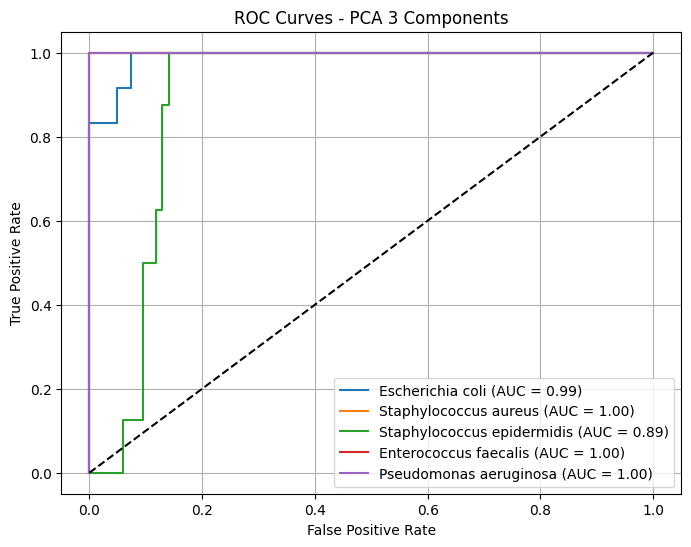

Training Logistic Regression on PCA 95% Variance...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.



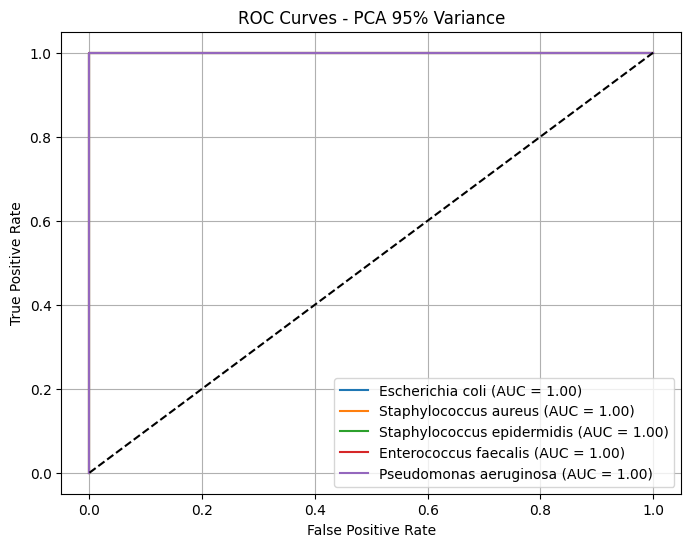

Mean ROC AUC PCA 3 components: 0.9765
Mean ROC AUC PCA 95% variance: 1.0000

Best model selected: PCA 95% Variance

Top 5 features for Escherichia coli (PCA 95% Variance) with true m/z values:
  Bin: 809, m/z: 4427.0, Coefficient: 0.2058
  Bin: 808, m/z: 4424.0, Coefficient: 0.1971
  Bin: 803, m/z: 4409.0, Coefficient: 0.1900
  Bin: 802, m/z: 4406.0, Coefficient: 0.1464
  Bin: 804, m/z: 4412.0, Coefficient: 0.1409


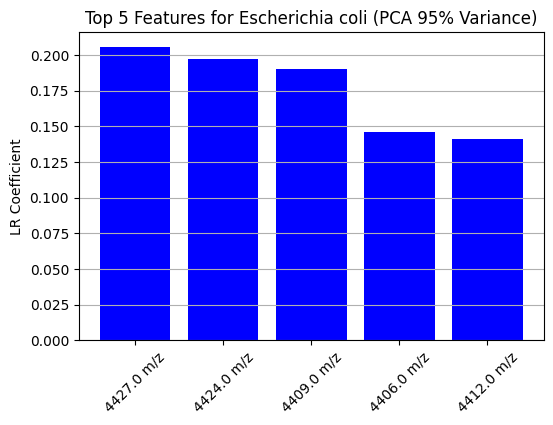


Top 5 features for Staphylococcus aureus (PCA 95% Variance) with true m/z values:
  Bin: 787, m/z: 4361.0, Coefficient: 0.4159
  Bin: 1418, m/z: 6254.0, Coefficient: 0.3715
  Bin: 788, m/z: 4364.0, Coefficient: 0.3454
  Bin: 1127, m/z: 5381.0, Coefficient: 0.3291
  Bin: 1126, m/z: 5378.0, Coefficient: 0.3165


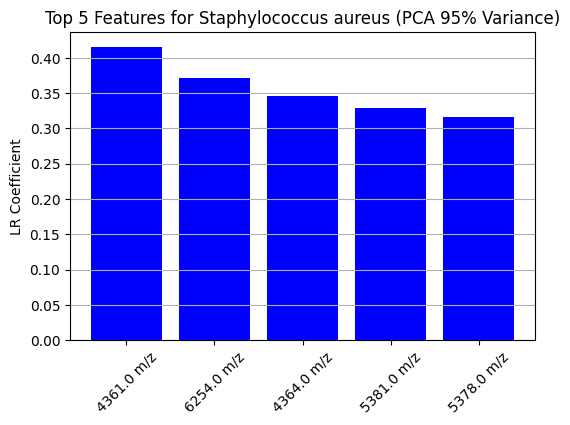


Top 5 features for Staphylococcus epidermidis (PCA 95% Variance) with true m/z values:
  Bin: 811, m/z: 4433.0, Coefficient: 0.1131
  Bin: 1245, m/z: 5735.0, Coefficient: 0.1120
  Bin: 1069, m/z: 5207.0, Coefficient: 0.1082
  Bin: 1070, m/z: 5210.0, Coefficient: 0.1003
  Bin: 1246, m/z: 5738.0, Coefficient: 0.0978


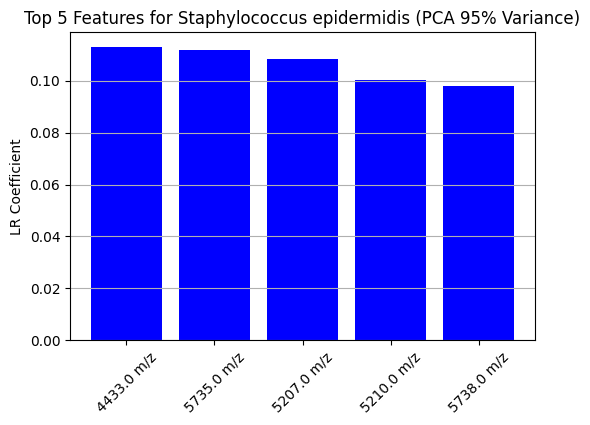


Top 5 features for Enterococcus faecalis (PCA 95% Variance) with true m/z values:
  Bin: 768, m/z: 4304.0, Coefficient: 0.3293
  Bin: 767, m/z: 4301.0, Coefficient: 0.2871
  Bin: 1629, m/z: 6887.0, Coefficient: 0.2285
  Bin: 769, m/z: 4307.0, Coefficient: 0.2266
  Bin: 1630, m/z: 6890.0, Coefficient: 0.2175


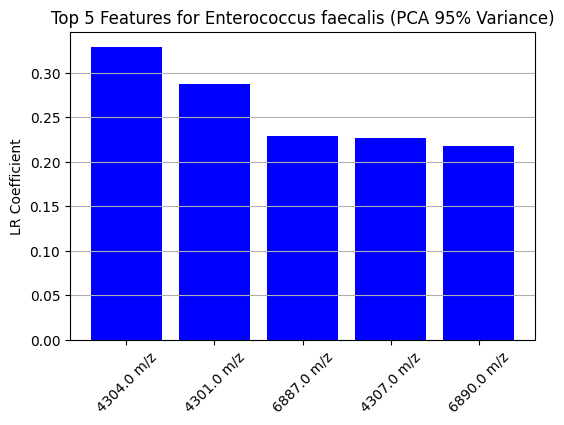


Top 5 features for Pseudomonas aeruginosa (PCA 95% Variance) with true m/z values:
  Bin: 763, m/z: 4289.0, Coefficient: 0.2748
  Bin: 1560, m/z: 6680.0, Coefficient: 0.2610
  Bin: 1561, m/z: 6683.0, Coefficient: 0.2539
  Bin: 764, m/z: 4292.0, Coefficient: 0.2386
  Bin: 446, m/z: 3338.0, Coefficient: 0.2050


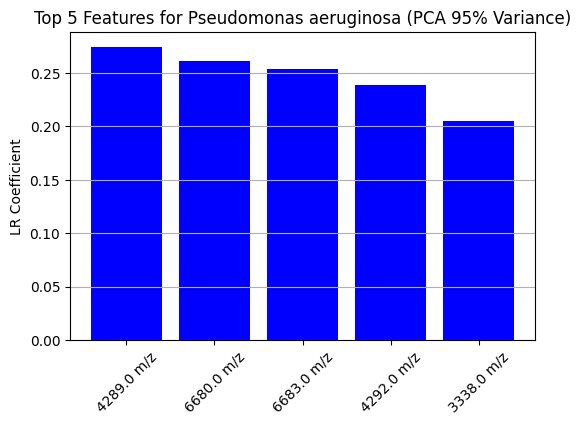

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from collections import Counter

# Filter function to select samples of top species
def filter_data(X, y, species_list, metadata):
    idxs = metadata[metadata['species'].isin(species_list)].index
    return X[idxs], y[idxs]

# Get top 5 species by frequency in training set
top5_species = [sp for sp, _ in Counter(metadata_train['species']).most_common(5)]

# Filter train and validation data for top 5 species
X_train_pca3_top5, y_train_top5 = filter_data(X_train_pca3, y_train, top5_species, metadata_train)
X_val_pca3_top5, y_val_top5 = filter_data(X_val_pca3, y_val, top5_species, metadata_val)

X_train_pca95_top5, _ = filter_data(X_train_pca95, y_train, top5_species, metadata_train)
X_val_pca95_top5, _ = filter_data(X_val_pca95, y_val, top5_species, metadata_val)

class_names_top5 = top5_species

def train_lr_and_plot_roc(X_train, y_train, X_val, y_val, class_names, description):
    # Train Logistic Regression with One-vs-Rest setting
    lr = LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear', random_state=42)
    lr.fit(X_train, y_train)

    # Binarize validation labels for ROC curve calculation
    unique_classes = np.unique(y_train)
    y_val_bin = label_binarize(y_val, classes=unique_classes)

    y_score = lr.predict_proba(X_val)

    plt.figure(figsize=(8,6))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {description}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return lr

print("Training Logistic Regression on PCA 3 Components...")
lr_pca3 = train_lr_and_plot_roc(X_train_pca3_top5, y_train_top5, X_val_pca3_top5, y_val_top5, class_names_top5, "PCA 3 Components")

print("Training Logistic Regression on PCA 95% Variance...")
lr_pca95 = train_lr_and_plot_roc(X_train_pca95_top5, y_train_top5, X_val_pca95_top5, y_val_top5, class_names_top5, "PCA 95% Variance")

# Choose best model based on average ROC AUC across classes on validation set
def mean_roc_auc(lr, X_val, y_val, unique_classes):
    y_score = lr.predict_proba(X_val)
    y_val_bin = label_binarize(y_val, classes=unique_classes)
    aucs = []
    for i in range(len(unique_classes)):
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_score[:, i])
        aucs.append(auc(fpr, tpr))
    return np.mean(aucs)

mean_auc_pca3 = mean_roc_auc(lr_pca3, X_val_pca3_top5, y_val_top5, np.unique(y_train_top5))
mean_auc_pca95 = mean_roc_auc(lr_pca95, X_val_pca95_top5, y_val_top5, np.unique(y_train_top5))

print(f"Mean ROC AUC PCA 3 components: {mean_auc_pca3:.4f}")
print(f"Mean ROC AUC PCA 95% variance: {mean_auc_pca95:.4f}")

best_model = lr_pca95 if mean_auc_pca95 >= mean_auc_pca3 else lr_pca3
best_desc = "PCA 95% Variance" if mean_auc_pca95 >= mean_auc_pca3 else "PCA 3 Components"

print(f"\nBest model selected: {best_desc}")

# Map coefficients back to original feature space

# Select PCA used in best model
pca_used = pca_95 if best_desc == "PCA 95% Variance" else pca_3

# LR coefficients in PCA space (num_classes, n_components)
coef_pca_space = best_model.coef_

# Transform coefficients to original feature space:
coef_original_space = coef_pca_space @ pca_used.components_

n_top_features = 5
feature_names = [f"m/z bin {i}" for i in range(X_train.shape[1])]  # Replace with actual m/z names if available

n_top_features = 5
# coef_original_space shape: (num_classes, n_features)
# class_names_top5 defined earlier

for i, class_name in enumerate(class_names_top5):
    coefs = coef_original_space[i]
    top_indices = np.argsort(np.abs(coefs))[-n_top_features:][::-1]

    true_mz_values = [(idx * 3) + 2000 for idx in top_indices]
    feature_labels = [f"{mz:.1f} m/z" for mz in true_mz_values]

    print(f"\nTop {n_top_features} features for {class_name} ({best_desc}) with true m/z values:")
    for idx, mz in zip(top_indices, true_mz_values):
        print(f"  Bin: {idx}, m/z: {mz:.1f}, Coefficient: {coefs[idx]:.4f}")

    plt.figure(figsize=(6,4))
    plt.bar(feature_labels, coefs[top_indices], color='b')
    plt.title(f"Top {n_top_features} Features for {class_name} ({best_desc})")
    plt.ylabel("LR Coefficient")
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.show()


## Logistic Regression with PCA (95%) — A naïve but powerful baseline

As we have observed, Logistic Regression trained on PCA-reduced data that explains 95% of the variance already achieves nearly **100% accuracy** on our validation set of the top 5 bacterial species from a single hospital.

This confirms the principle of **Occam’s Razor**: often, simple models can solve the problem effectively when the data is well-structured and limited in complexity. In this case, the LR model identifies clear biomarkers and decision boundaries, demonstrating that much of the information needed for classification is captured in a few principal components.

---

### However...

This scenario is somewhat **naïve and limited**:

- We focused only on the **top 5 most common bacteria** in the dataset.  
- Data originates from **a single hospital**, with relatively homogeneous conditions and sample preparation.  
- Real-world clinical microbiology involves **many more species**, samples from **multiple hospitals** with different acquisition protocols, and greater biological variability.

In such complex, heterogeneous environments, **more sophisticated models** capable of capturing non-linear interactions and adapting to varied data distributions are often necessary.

---

### Next Steps

To address these challenges, we will now implement and evaluate **more advanced models**, including:

- **XGBoost**, a powerful gradient-boosted tree ensemble method that can capture complex, non-linear relationships and interactions between MALDI-TOF peaks.  
- Additional models that provide complementary strengths in robustness, interpretability, and predictive performance.

This progression aligns with the model selection strategy discussed earlier—start simple, then move towards complexity as needed based on data characteristics and problem difficulty.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[11:57:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




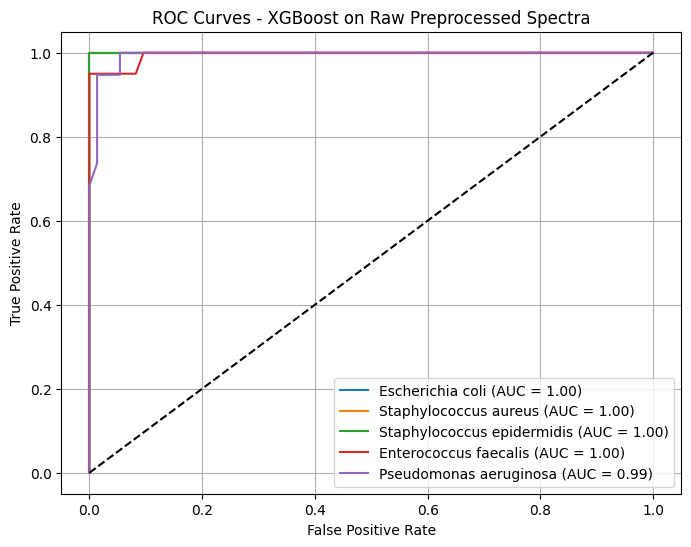

Top 10 features by XGBoost importance with true m/z values:
  Feature bin: 787, m/z: 4361.0, Importance (weight): 19.0
  Feature bin: 767, m/z: 4301.0, Importance (weight): 19.0
  Feature bin: 919, m/z: 4757.0, Importance (weight): 18.0
  Feature bin: 1069, m/z: 5207.0, Importance (weight): 16.0
  Feature bin: 764, m/z: 4292.0, Importance (weight): 8.0
  Feature bin: 2291, m/z: 8873.0, Importance (weight): 5.0
  Feature bin: 2403, m/z: 9209.0, Importance (weight): 5.0
  Feature bin: 814, m/z: 4442.0, Importance (weight): 2.0
  Feature bin: 127, m/z: 2381.0, Importance (weight): 1.0
  Feature bin: 49, m/z: 2147.0, Importance (weight): 1.0


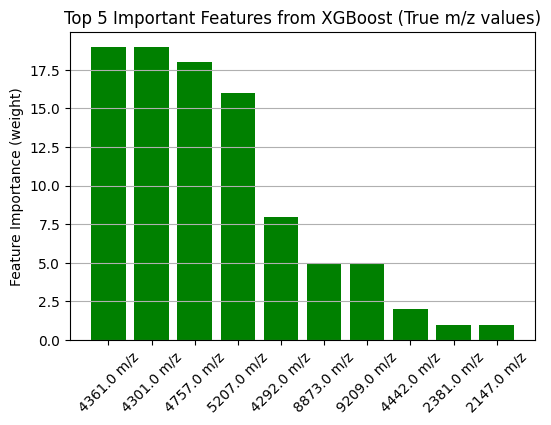

In [ ]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Filter data to top 5 species
top5_species = [sp for sp, _ in Counter(metadata_train['species']).most_common(5)]

def filter_data(X, y, species_list, metadata):
    idxs = metadata[metadata['species'].isin(species_list)].index
    return X[idxs], y[idxs]

# Filter training and validation data for top 5 species
X_train_top5, y_train_top5 = filter_data(X_train, y_train, top5_species, metadata_train)
X_val_top5, y_val_top5 = filter_data(X_val, y_val, top5_species, metadata_val)

# Map label integers to species names for top5
class_names_top5 = top5_species
le_top5 = LabelEncoder()
y_train_top5_enc = le_top5.fit_transform(metadata_train.loc[metadata_train['species'].isin(top5_species), 'species'])
y_val_top5_enc = le_top5.transform(metadata_val.loc[metadata_val['species'].isin(top5_species), 'species'])

# Train XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    random_state=42
)
xgb_clf.fit(X_train_top5, y_train_top5_enc)

# Predict probabilities for ROC
y_val_proba = xgb_clf.predict_proba(X_val_top5)

# Binarize validation labels
y_val_bin = label_binarize(y_val_top5_enc, classes=range(len(class_names_top5)))

# Plot ROC curves for top 5 species
plt.figure(figsize=(8, 6))
colors = plt.cm.tab10.colors  # up to 10 colors

for i, class_name in enumerate(class_names_top5):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_val_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - XGBoost on Raw Preprocessed Spectra')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Extract feature importance from XGBoost
importance_dict = xgb_clf.get_booster().get_score(importance_type='weight')
# importance_type options: weight, gain, cover; 'weight' = number of times feature is used in trees

# Map feature names
feature_names = [f"m/z bin {i}" for i in range(X_train.shape[1])]  # Replace with real m/z names if available

# Convert importance dict keys (like 'f0', 'f1', ...) to integers and values to array
importance_arr = np.zeros(X_train.shape[1])
for k, v in importance_dict.items():
    idx = int(k[1:])  # strip 'f' prefix
    importance_arr[idx] = v

# For each top species, plot top 5 important features according to global importance
# (XGBoost feature importance is global, not per class)

top_n = 10
top_indices = np.argsort(importance_arr)[-top_n:][::-1]

true_mz_values = [(idx * 3) + 2000 for idx in top_indices]
feature_labels = [f"{mz:.1f} m/z" for mz in true_mz_values]

print(f"Top {top_n} features by XGBoost importance with true m/z values:")
for idx, mz in zip(top_indices, true_mz_values):
    print(f"  Feature bin: {idx}, m/z: {mz:.1f}, Importance (weight): {importance_arr[idx]}")

plt.figure(figsize=(6, 4))
plt.bar(feature_labels, importance_arr[top_indices], color='green')
plt.title("Top 5 Important Features from XGBoost (True m/z values)")
plt.ylabel("Feature Importance (weight)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [ ]:
#Save model
import joblib

joblib.dump(xgb_clf, "/content/drive/MyDrive/ESCMID-AI-Data-Advances-Techniques/Models/xgboost_top5_species_model.pkl")

['/content/drive/MyDrive/ESCMID-AI-Data-Advances-Techniques/Models/xgboost_top5_species_model.pkl']

**MLP**


**What is an MLP?**

An MLP (Multilayer Perceptron) is a type of artificial neural network used to model relationships in data. It learns to map input data to output labels or values by adjusting internal parameters (called weights) during training.

At its core, an MLP is made up of layers of neurons:
*   Input Layer – where data enters the model.
*   Hidden Layers – one or more layers where the actual computation happens
*   Output Layer – where the result (such as a prediction) comes out.

**How Does It Work?**
When you feed data into an MLP, it goes through the following steps:

Linear Transformation: Each neuron in a layer takes inputs from the previous layer, multiplies them by some weights, and adds a bias.
Mathematically, this is expressed as:

$$
z = w_1x_1 + w_2x_2 + \cdots + w_nx_n + b
$$

Where:

- $x_1, x_2, \ldots, x_n$ are the input features  
- $w_1, w_2, \ldots, w_n$ are the corresponding weights  
- $b$ is the bias term  
- $z$ is the linear output before activation

Activation Function: The result 𝑧
z is then passed through a nonlinear function (like ReLU or sigmoid), which introduces complexity so the network can learn things like curves or patterns—not just straight lines.


Examples:

- **ReLU** (Rectified Linear Unit):

  $$
  \text{ReLU}(z) = \max(0, z)
  $$

- **Sigmoid**:

  $$
  \text{Sigmoid}(z) = \frac{1}{1 + e^{-z}}
  $$



**How Does It Learn?**

MLPs learn from data using a process called backpropagation and an optimization algorithm (like gradient descent):

The model makes a guess (called a prediction) for the input.

1.   It compares the prediction to the actual answer using a loss function.
2.   It calculates how wrong it was and adjusts its weights to do better next time.
3.   This adjustment happens many times over many examples in the training data, gradually improving performance.

**MLP using SKlearn package**

In [ ]:
# Create here MLP model using sklearn package

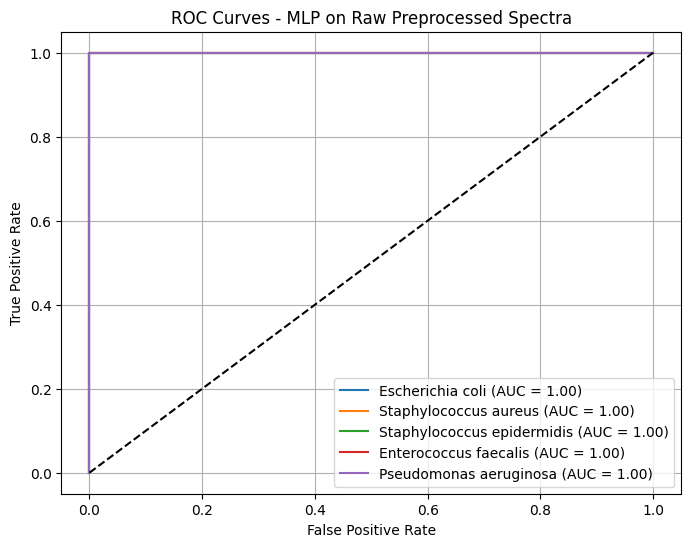

In [ ]:
# Create here ROC cures on test set

## MLP using tensorflow Keras


---
MLP can also be implemented using Tensorflow or Pytorch. These common frameworks to also develop deeplearning models.


In [ ]:
import numpy as np
import shap
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# --- 1. Preprocessing (same as sklearn pipeline) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_top5)
X_val_scaled = scaler.transform(X_val_top5)  # use same scaler for test

# --- 2. Define MLP model using Keras ---
n_features = X_train_scaled.shape[1]
n_classes = len(np.unique(y_train_top5_enc))  # multi-class

# Define model properly
mlp_keras = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(10, activation='relu'),
    Dense(n_classes, activation='softmax')  # or Dense(1, activation='sigmoid') for binary
])

# 3. Train MLP model
mlp_keras.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_keras.fit(X_train_scaled, y_train_top5_enc, epochs=10, batch_size=16, verbose=0)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


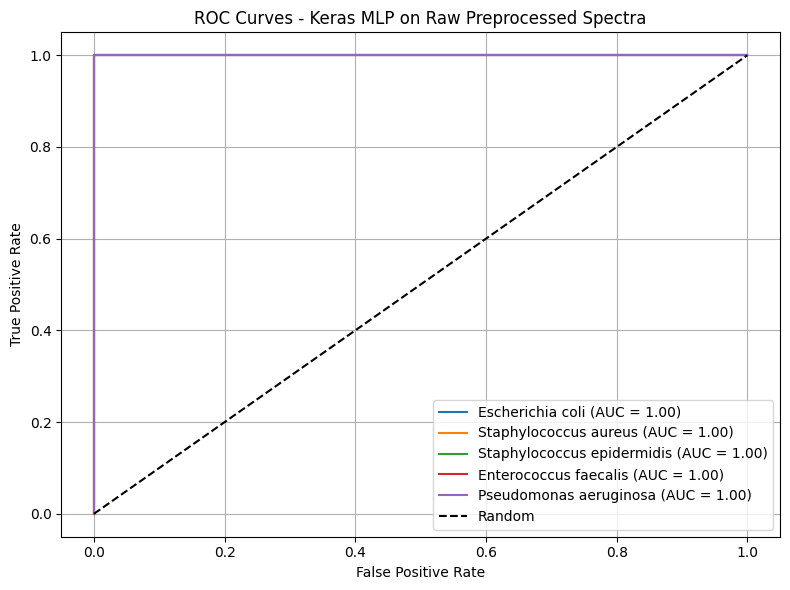

In [ ]:
# --- 1. Predict class probabilities on validation set
y_val_proba_mlp = mlp_keras.predict(X_val_scaled)  # shape: (n_samples, n_classes)

# --- 2. Plot ROC curves per class
plt.figure(figsize=(8, 6))

for i, class_name in enumerate(class_names_top5):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_val_proba_mlp[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

# --- 3. Plot diagonal line (random classifier baseline)
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# --- 4. Format plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Keras MLP on Raw Preprocessed Spectra')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# SHAP values

**Explainability: SHAP values (SHapley Additive exPlanations)**

SHAP is a powerful library to explain predictions of any machine learning model, including neural networks.

Shapley Values (SHAP)

**What are they?**

Shapley values come from cooperative game theory. They fairly distribute the “payout” (in machine learning, the prediction) among all the “players” (features) based on their contribution.

**How does it work in ML?**


Imagine each feature as a player in a team.

The team’s “score” is the model’s prediction.

Shapley values tell you how much each feature contributes to moving the prediction from the average prediction to the current output.

They do this by averaging the feature’s contribution over all possible combinations of features.


In [ ]:
# 4. SHAP DeepExplainer using NumPy (not tf.Tensor)


# 5. Summary plot

# Rename features


# 6. Summary plot for one class
